# Manuscript3 - Analysis of Intrinsic Network FC Properties for Fig. 3


## Master code for Ito et al., 2017¶
#### Takuya Ito (takuya.ito@rutgers.edu)


In [1]:
import sys
sys.path.append('utils/')
import numpy as np
import loadGlasser as lg
import scipy.stats as stats
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import sys
import multiprocessing as mp
import pandas as pd
import multregressionconnectivity as mreg
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import permutationTesting as pt
import os
os.environ['OMP_NUM_THREADS'] = str(1)

# 1.0 Basic parameters

In [2]:
# Set basic parameters
basedir = '/projects2/ModalityControl2/'
datadir = basedir + 'data/'
resultsdir = datadir + 'resultsMaster/'
runLength = 4648

subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

glasserparcels = lg.loadGlasserParcels()
networkdef = lg.loadGlasserNetworks()
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1
aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
networkdef[aud2_ind] = networkmappings['aud1']
# Define new network mappings with no aud1/aud2 distinction
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11}

# Define new network mappings with no aud1/aud2 distinction
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11,
                   'prem':5, 'pcc':10, 'none':12, 'hipp':13, 'pmulti':14}

# Import network reordering
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
order = networkorder
order.shape = (len(networkorder),1)
# Construct xticklabels and xticks
networks = networkmappings.keys()
xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
networks = networkmappings.keys()
for net in networks:
    ind = np.sum(networkdef==networkmappings[net])
    print net, ind

dan 23
vis 56
prem 2
none 7
aud 31
pmulti 6
fpn 43
dmn 77
smn 41
pcc 2
hipp 15
con 53


In [5]:
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}
print netkeys

{0: 'fpn', 1: 'dan', 2: 'con', 3: 'dmn', 4: 'vis', 5: 'aud', 6: 'smn'}


# 2.0 Compute out-of-network intrinsic FC for each network (rest)

In [4]:
# Compute rsfcMRI using multiple linear regression on Glasser parcels
fcmat_multreg = np.zeros((360,360,len(subjNums)))
scount = 0
for subj in subjNums:
    outdir = '/projects2/ModalityControl2/data/resultsMaster/MultRegConnRestFC_GlasserParcels/'
    outfile = subj + '_multregconn_restfc.csv'
    fcmat_multreg[:,:,scount] = np.loadtxt(outdir + outfile, delimiter=',')
    scount += 1


## Interm analysis - visualize MultRegFC matrix using Glasser networks

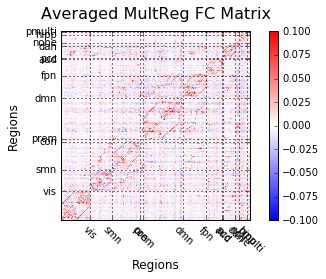

In [6]:
tmp = np.mean(fcmat_multreg,axis=2)
plt.figure()
norm = MidpointNormalize(midpoint=0)
plt.imshow(tmp[order,order.T], norm=norm, origin='lower', cmap='bwr', vmin=-.1, vmax=.1)
plt.colorbar(fraction=0.046)
plt.title('Averaged MultReg FC Matrix',
          fontsize=16, y=1.04)
plt.xlabel('Regions',fontsize=12)
plt.ylabel('Regions', fontsize=12)
plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
plt.yticks(xticks.keys(),xticks.values())
plt.grid(linewidth=1)
plt.tight_layout()
# plt.savefig('Group_MultRegFC.pdf')

## Visualize Regular FC matrix using Glasser networks

In [7]:
timeseries = np.zeros((360,360,len(subjNums)))
scount = 0
for subj in subjNums:
    indir = '/projects2/ModalityControl2/data/resultsMaster/glmRest_GlasserParcels/'
    filename = indir + subj + '_rest_nuisanceResids_Glasser.csv'
    tmp = np.loadtxt(filename, delimiter=',')
    timeseries[:,:,scount] = np.corrcoef(tmp)
    scount += 1

#### Visualize data

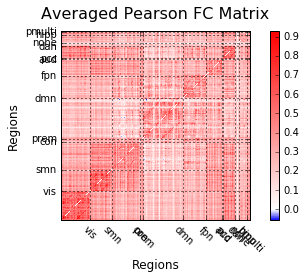

In [8]:
mat = np.mean(timeseries,axis=2)
np.fill_diagonal(mat,0)
mat = mat[order,order.T]
norm = MidpointNormalize(midpoint=0)
plt.imshow(mat,origin='lower',norm=norm, cmap='bwr', interpolation='none')
plt.colorbar(fraction=0.046)
plt.title('Averaged Pearson FC Matrix',
          fontsize=16, y=1.04)
plt.xlabel('Regions',fontsize=12)
plt.ylabel('Regions', fontsize=12)
plt.xticks(xticks.keys(),xticks.values(), rotation=-45)
plt.yticks(xticks.keys(),xticks.values())
plt.grid(linewidth=1)
plt.tight_layout()
# plt.savefig('Group_PearsonFC.pdf')

#### Compute BGC

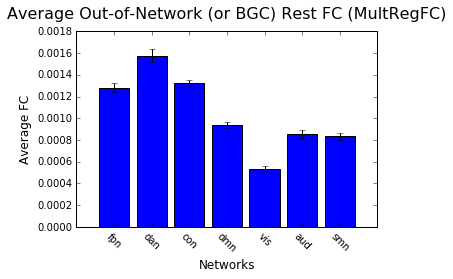

In [9]:
network_gbc = {}
outofnet_gbc = {}


for net in netkeys.keys():
    network_gbc[net] = []
    outofnet_gbc[net] = []
    
    net_ind = np.where(networkdef==networkmappings[netkeys[net]])[0]
    outofnet_ind = np.where(networkdef!=networkmappings[netkeys[net]])[0]

    scount = 0
    for subj in subjNums:
        tmp_outofnet = []
        tmp_gbc = []
        for roi in net_ind:
            tmp_outofnet.append(np.mean(fcmat_multreg[roi,outofnet_ind,scount]))
#             tmp_outofnet.append(np.mean(fcmat_multreg[roi,:,scount]))

            tmp_gbc.append(np.mean(fcmat_multreg[roi,:,scount]))

        outofnet_gbc[net].append(np.mean(tmp_outofnet))
        network_gbc[net].append(np.mean(tmp_gbc))

        scount += 1

outofnet_avg = {}
outofnet_sem = {}
network_avg = {}
network_sem = {}
for net in netkeys.keys():
    outofnet_avg[net] = np.mean(outofnet_gbc[net])
    outofnet_sem[net] = np.std(outofnet_gbc[net])/np.sqrt(len(subjNums))
    network_avg[net] = np.mean(network_gbc[net])
    network_sem[net] = np.std(network_gbc[net])/np.sqrt(len(subjNums))
    
## Plot average Out-of-Network FC
# width = .35
nbars = len(netkeys)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(nbars), outofnet_avg.values(), align='center',
                     yerr=outofnet_sem.values(), color='b', error_kw=dict(ecolor='black'))
ax.set_title('Average Out-of-Network (or BGC) Rest FC (MultRegFC)',
             y=1.04, fontsize=16)
ax.set_ylabel('Average FC',fontsize=12)
ax.set_xlabel('Networks', fontsize=12)
ax.set_xticks(np.arange(nbars))
ax.set_xticklabels(netkeys.values(),rotation=-45)
# ax.set_ylim([0.0025,.003])
plt.tight_layout()
# plt.savefig('Fig1_OutOfNetworkRestFC_MultReg.pdf')


### Compute statistics using FWER - see if FPN is greater than all other networks

In [10]:
netkeys

{0: 'fpn', 1: 'dan', 2: 'con', 3: 'dmn', 4: 'vis', 5: 'aud', 6: 'smn'}

In [11]:
outofnet_avg

{0: 0.0012813032801977154,
 1: 0.0015738253972098018,
 2: 0.0013236617486063235,
 3: 0.00093901800604968702,
 4: 0.0005311922911008988,
 5: 0.00085217918406622201,
 6: 0.00083446398253166131}

In [12]:
outofnet_stats = {}
ps = []
diff_gbc = {}
ccns = ['fpn','dan','con']
ccnkeys = {'fpn':0, 'dan':1, 'con':2}
for ccn in ccns:
    ccnkey = ccnkeys[ccn]
    diff_gbc[ccn] = np.zeros((len(netkeys)-len(ccns),len(subjNums)))
    outofnet_stats[ccn] = {}
    count = 0
    for net in netkeys.keys():
        outofnet_stats[ccn][net] = {}
        if net==ccn: continue
        outofnet_stats[ccn][net]['T-value'], outofnet_stats[ccn][net]['p-value'] = stats.ttest_rel(outofnet_gbc[ccnkey], 
                                                                                 outofnet_gbc[net])
        if netkeys[net] not in ccns:
            diff_gbc[ccn][count,:] = np.asarray(outofnet_gbc[ccnkey]) - np.asarray(outofnet_gbc[net])
            count += 1
        # Correct to 1-sided t-test
        if outofnet_stats[ccn][net]['T-value'] < 0:
            outofnet_stats[ccn][net]['p-value'] = 1-(outofnet_stats[ccn][net]['p-value']/2.0)
        else:
            outofnet_stats[ccn][net]['p-value'] = outofnet_stats[ccn][net]['p-value']/2.0

        ps.append(outofnet_stats[ccn][net]['p-value'])
    
# We know that FPN is the 0th network key. So exclude this network when running multiple comparsisons

    
# tmp = mc.fdrcorrection0(ps)[1]
for ccn in ccns:
    ccnkey = ccnkeys[ccn]
    avg_t = []
    count = 0
    
    tmp = np.delete(diff_gbc,ccnkey,axis=0)
    t_fwe, p_fwe = pt.permutationFWE(diff_gbc[ccn], nullmean=0, permutations=1000, nproc=10)
    p_fwe = 1.0 - p_fwe
    
    for net in outofnet_avg.keys():
        if netkeys[net] == ccn: continue
        j = 0
        if count <=1:
            outofnet_stats[ccn][net]['p-value (FWE-corrected)'] = np.nan
        else:
            outofnet_stats[ccn][net]['p-value (FWE-corrected)'] = round(p_fwe[j],3)
            j += 1
        outofnet_stats[ccn][net]['p-value'] = round(outofnet_stats[ccn][net]['p-value'],4)
        outofnet_stats[ccn][net]['T-value'] = round(outofnet_stats[ccn][net]['T-value'],4)
        if netkeys[net] not in ccns:
            avg_t.append(round(outofnet_stats[ccn][net]['T-value'],4))
        count += 1
        
    print 'Average t of', ccn, 'greater than non-ccn:', np.mean(avg_t)
    print 'Average effect size of', ccn, ':', np.mean(outofnet_gbc[ccnkey])
    df_outofnet_stats = pd.DataFrame(outofnet_stats[ccn])
    display(df_outofnet_stats)
    print '\n'

Average t of fpn greater than non-ccn: 9.517225
Average effect size of fpn : 0.0012813032802


,0,1,2,3,4,5,6
T-value,NaN,-4.2492,-0.7733,6.505,15.0556,7.068,9.4403
p-value,NaN,0.9999,0.7774,0.000,0.0000,0.000,0.0000
p-value (FWE-corrected),NaN,NaN,NaN,0.000,0.0000,0.000,0.0000




Average t of dan greater than non-ccn: 11.55995
Average effect size of dan : 0.00157382539721


,0,1,2,3,4,5,6
T-value,4.2492,NaN,3.5870,10.8703,14.5752,10.448,10.3463
p-value,0.0001,NaN,0.0006,0.0000,0.0000,0.000,0.0000
p-value (FWE-corrected),NaN,NaN,NaN,0.0000,0.0000,0.000,0.0000




Average t of con greater than non-ccn: 12.328875
Average effect size of con : 0.00132366174861


,0,1,2,3,4,5,6
T-value,0.7733,-3.5870,NaN,9.7933,20.1731,9.0207,10.3284
p-value,0.2226,0.9994,NaN,0.0000,0.0000,0.0000,0.0000
p-value (FWE-corrected),NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
